In [4]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import xgboost as xgb
import os

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 1.0/101.7 MB 4.7 MB/s eta 0:00:22
    --------------------------------------- 2.4/101.7 MB 5.7 MB/s eta 0:00:18
   - -------------------------------------- 3.7/101.7 MB 6.1 MB/s eta 0:00:17
   - -------------------------------------- 4.2/101.7 MB 5.4 MB/s eta 0:00:19
   -- ------------------------------------- 5.2/101.7 MB 5.1 MB/s eta 0:00:19
   -- ------------------------------------- 6.3/101.7 MB 4.9 MB/s eta 0:00:20
   -- ------------------------------------- 6.8/101.7 MB 4.6 MB/s eta 0:00:21
   -- ------------------------------------- 7.3/101.7 MB 4.4 MB/s eta 0:00:22
   --- ------------------------------------ 8.1/101.7 MB 4.2 MB/s eta 0:00:23
   --- ------------------------------------ 8.9/101.7 MB 4.1 MB/s eta 0:00:23
   --- ------------------------------------ 9.4/101.7 MB 4.0 MB/s eta 0:00:23


In [76]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [77]:
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

In [78]:
train_df['SalePrice'].skew()

np.float64(1.8828757597682129)

Distribution of Sales Prizes

Text(0.5, 0, 'Sale Price')

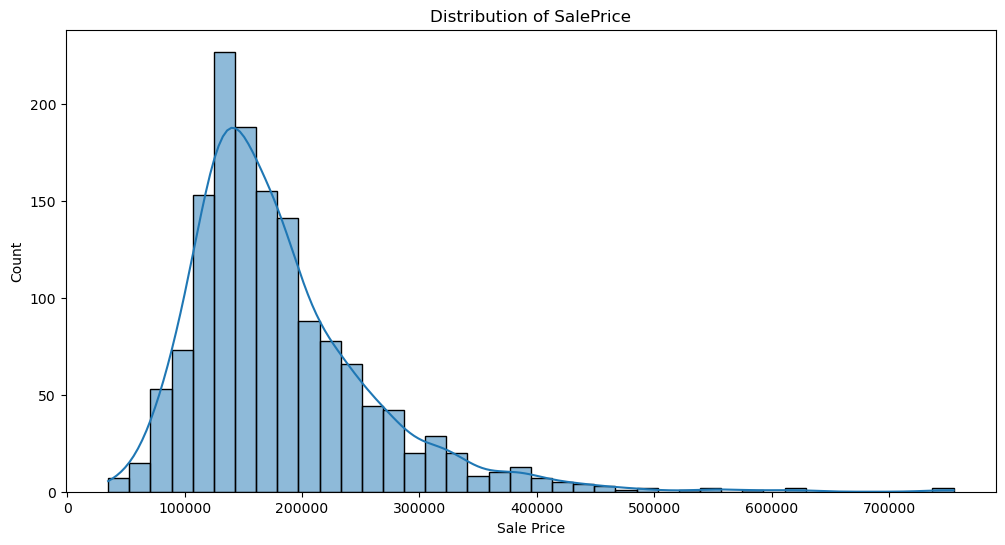

In [79]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=40)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')

the distribution is right skewed to fix this we have to apply the log trasformation

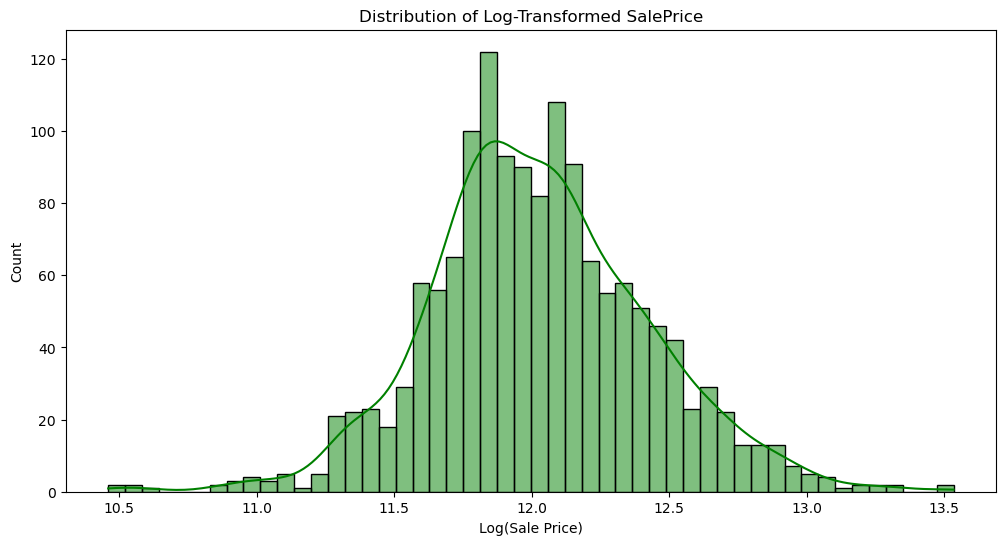

Skewness of Log-Transformed SalePrice: 0.12134661989685333


In [80]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {train_df['SalePrice'].skew()}")

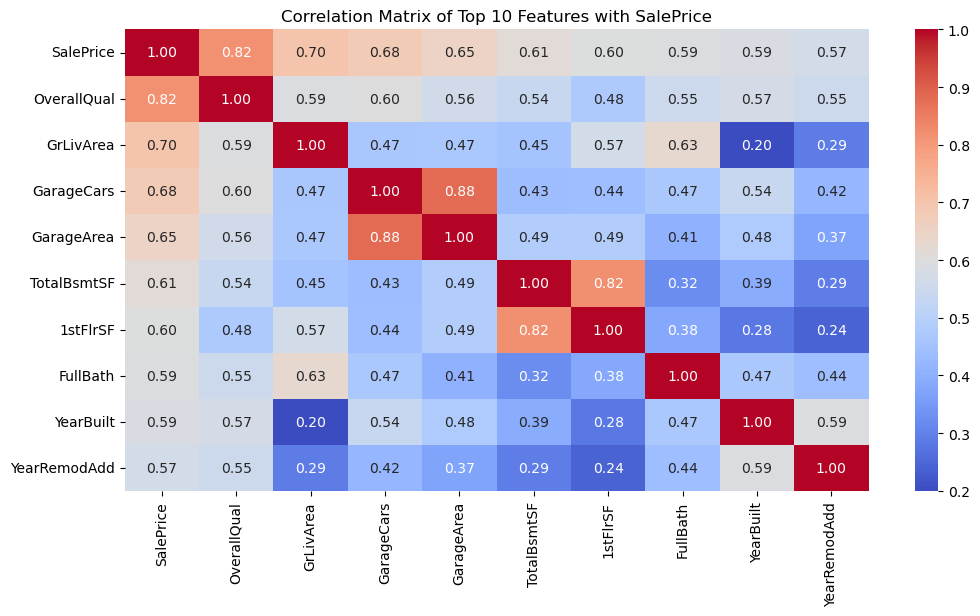

In [81]:
corr = train_df.corr(numeric_only=True)
top_corr= corr.nlargest(10,'SalePrice')['SalePrice'].index
corr_matrix = train_df[top_corr].corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

***Highly Correlated Values***
* saleprice & Overall Quality
* Ground living Area & Saleprice
* GarageCars & GarageArea
* Total basement sf & 1st flrsf
* Ground living area is also related with Full bathroom

In [82]:
Full_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:,:'SaleCondition']))

print(f"Combined data shape: {Full_data.shape}")

Combined data shape: (2919, 79)


In [83]:
missing_data=Full_data.isna().sum().sort_values(ascending=False)
print(missing_data[missing_data>0])

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
BsmtFullBath       2
Functional         2
TotalBsmtSF        1
BsmtFinSF1         1
SaleType           1
BsmtFinSF2         1
GarageCars         1
Exterior2nd        1
Exterior1st        1
GarageArea         1
KitchenQual        1
BsmtUnfSF          1
Electrical         1
dtype: int64


In [84]:
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in Full_data.columns:
        Full_data[col] = Full_data[col].fillna(0)

Full_data[numerical_cols_to_impute_zero].isna().sum()

MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
GarageCars      0
GarageArea      0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

In [85]:
# Impute LotFrontage with the median of the neighborhood
if 'LotFrontage' in Full_data.columns and Full_data['LotFrontage'].isna().any():
    Full_data['LotFrontage'] = Full_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Full_data['Alley'].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [86]:
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in Full_data.columns:
        Full_data[col] = Full_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    # Check if column exists after one-hot encoding
    if col in Full_data.columns:
        Full_data[col] = Full_data[col].fillna(Full_data[col].mode()[0])

In [87]:
Full_data['GarageYrBlt'].value_counts()

GarageYrBlt
2005.0    142
2006.0    115
2007.0    115
2004.0     99
2003.0     92
         ... 
1908.0      1
1896.0      1
1933.0      1
1906.0      1
1919.0      1
Name: count, Length: 103, dtype: int64

In [88]:
Full_data.isnull().sum().sum()

np.int64(159)

In [89]:
if 'GarageYrBlt' in Full_data.columns:
    Full_data['GarageYrBlt'] = Full_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", Full_data.isna().sum().sum())


Missing values after all imputation: 0


In [90]:
Full_data.isnull().sum().sum()

np.int64(0)

In [93]:
Full_data['TotalSF'] = Full_data['TotalBsmtSF'] + Full_data['1stFlrSF'] + Full_data['2ndFlrSF']

Full_data['TotalBath'] = (Full_data['FullBath'] + (0.5 * Full_data['HalfBath']) +
                         Full_data['BsmtFullBath'] + (0.5 * Full_data['BsmtHalfBath']))

Full_data['Age'] = Full_data['YrSold'] - Full_data['YearBuilt']

### label encoding

In [94]:
categorical_cols = Full_data.select_dtypes(include=['object']).columns

Full_data = pd.get_dummies(Full_data,columns=categorical_cols,drop_first=True)

### Model Building

In [95]:
X = Full_data[:len(train_df)]
y = train_df['SalePrice']
X_test_final = Full_data[len(train_df):]

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_val

Id
893     11.947956
1106    12.691584
414     11.652696
523     11.976666
1037    12.661917
          ...    
480     11.401681
1362    12.468441
803     12.149508
652     11.589896
723     11.732069
Name: SalePrice, Length: 292, dtype: float64

In [98]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [101]:
X_train.head()
X_train_scaled

array([[-0.8667643 , -0.01933867, -0.21289571, ..., -0.12510865,
         0.46001984, -0.30263639],
       [ 0.07410996, -0.50039047, -0.26524463, ..., -0.12510865,
         0.46001984, -0.30263639],
       [-0.63154574, -0.15053462, -0.17784146, ..., -0.12510865,
         0.46001984, -0.30263639],
       ...,
       [-0.8667643 , -0.45665849, -0.23409563, ..., -0.12510865,
         0.46001984, -0.30263639],
       [-0.16110861, -0.6753184 , -0.28337613, ..., -0.12510865,
         0.46001984, -0.30263639],
       [ 1.48542135, -0.76278236, -0.65139925, ..., -0.12510865,
         0.46001984, -0.30263639]], shape=(1168, 262))

Scale the model for better performance & Machine understability

In [103]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

In [108]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
y_pred_lr = lr.predict(X_val_scaled)
y_pred_lr

array([11.94136732, 12.73981795, 11.51734525, 12.01487948, 12.64926257,
       11.28125177, 12.42367424, 11.89852165, 11.22643455, 11.86994258,
       11.88608842, 11.64392657, 11.23230401, 12.26138536, 12.07110195,
       11.80087308, 12.14706831, 11.78972384, 11.58284822, 12.2693948 ,
       11.92793845, 12.22406554, 12.07011723, 11.82560994, 12.19616524,
       11.89526696, 12.15166979, 11.60271912, 12.10684603, 12.1969508 ,
       12.08657634, 12.53744901, 12.30214298, 11.66556937, 12.45474616,
       11.93105985, 11.89189847, 12.19935819, 12.68351764, 11.58686028,
       11.80931906, 12.29662339, 11.60207364, 12.82646513, 11.75787557,
       11.74918942, 11.57708431, 11.81620749, 13.04562787, 11.8267837 ,
       11.7062313 , 12.24629524, 11.5574877 , 12.6258775 , 12.0258037 ,
       12.38911243, 12.22142841, 11.95688407, 11.78095167, 11.50236687,
       11.30197603, 11.9977707 , 12.64750084, 12.40696689, 12.60854943,
       12.19663563, 11.60748068, 12.68077664, 11.77433401, 12.06

### XgBoost Model

In [109]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', # Corrected objective function
                        n_estimators=10000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)

# XGBoost can handle NaNs, but since we've cleaned the data, we can use the scaled data as well if preferred.
# However, XGBoost generally doesn't require scaling. We'll use the unscaled data as it's a tree-based model.
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)

In [110]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")

# evaluate_model(y_val, y_pred_lr, "Linear Regression") # Commenting out Linear Regression evaluation as it failed
evaluate_model(y_val,y_pred_lr,'Linear Regression')
evaluate_model(y_val, y_pred_xgb, "XGBoost")

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389

--- XGBoost Performance ---
RMSE: 0.1338
MAE:  0.0856
R-squared: 0.9041



In [112]:
final_predictions_log = xgbr.predict(X_test_final)
final_predictions = np.expm1(final_predictions_log)
submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
submission.head()

Submission file 'submission.csv' created successfully.


,Id,SalePrice
0,1461,122916.281250
1,1462,163308.546875
2,1463,192141.718750
3,1464,194780.578125
4,1465,179370.218750
